In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import timm
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from PIL import Image
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Paths
csv_path  = "/content/drive/MyDrive/dataset/cleaned_dataset.csv"
model_save_path = "/content/drive/MyDrive/swin_classifier_tune.h5"

# Custom Dataset
class SickleCellDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join("/content/drive/MyDrive/dataset", self.data.iloc[idx, 0])
        label = int(self.data.iloc[idx, 1])  # Class (0 = Non-Sickle, 1 = Sickle)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Image Preprocessing & Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [3]:
# Load dataset
dataset = SickleCellDataset(csv_file=csv_path, transform=transform)

# Split dataset (80% Train, 10% Validation, 10% Test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [4]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [5]:
# ✅ Define Corrected Model
class SickleCellModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SickleCellModel, self).__init__()
        self.model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True)

        # Remove the default classifier head
        self.model.head = nn.Identity()

        # Custom Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(self.model.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)  # Output (batch_size, num_classes)
        )

    def forward(self, x):
        x = self.model(x)  # Swin Output -> (batch_size, 7, 7, 768)
        x = x.flatten(1, 2)  # Flatten spatial dimensions -> (batch_size, 49, 768)
        x = x.mean(dim=1)  # Global average pooling over patches -> (batch_size, 768)
        x = self.classifier(x)  # Fully connected classification
        return x

# ✅ Check Output Shape
model = SickleCellModel()
dummy_input = torch.randn(32, 3, 224, 224)  # Batch of 32 RGB images
output = model(dummy_input)
print(f"Output shape: {output.shape}")  # Should be (32, 2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Output shape: torch.Size([32, 2])


In [ ]:

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SickleCellModel().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# ✅ Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training Loop
num_epochs = 10
best_val_loss = float("inf")

# Lists for tracking metrics
# Lists for tracking metrics
train_losses, val_losses = [], []
train_accuracies = []  # Fixed
val_accuracies = []  # Fixed


for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # ✅ Debugging Shape
        print(f"DEBUG: outputs.shape = {outputs.shape}, labels.shape = {labels.shape}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step(avg_val_loss)  # Adjust LR if validation loss plateaus

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print("✅ Model saved!")

print("🎉 Training Complete!")

DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outputs.shape = torch.Size([32, 2]), labels.shape = torch.Size([32])
DEBUG: outpu

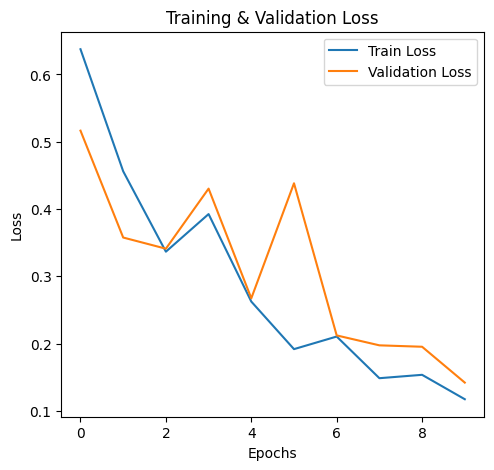

In [ ]:
# ✅ Plot Loss & Accuracy
plt.figure(figsize=(12, 5))

# 📊 Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

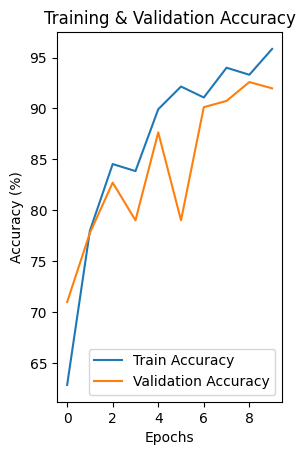

In [ ]:
# 📈 Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()

In [8]:
# ✅ Define Device (if not already defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load Model
model = SickleCellModel().to(device)  # Ensure model architecture is defined before loading
model.load_state_dict(torch.load(model_save_path))  # Load saved model
model.eval()  # Set model to evaluation mode

# ✅ Initialize Variables for Evaluation
correct, total = 0, 0
all_preds, all_labels, all_probs = [], [], []

# ✅ Evaluate on Test Set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probability of class 1 (Sickle Cell)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())  # Convert to NumPy for sklearn
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Convert to NumPy

# ✅ Calculate Overall Accuracy
test_acc = 100 * correct / total
print(f"✅ Test Accuracy: {test_acc:.2f}%")

✅ Test Accuracy: 94.51%


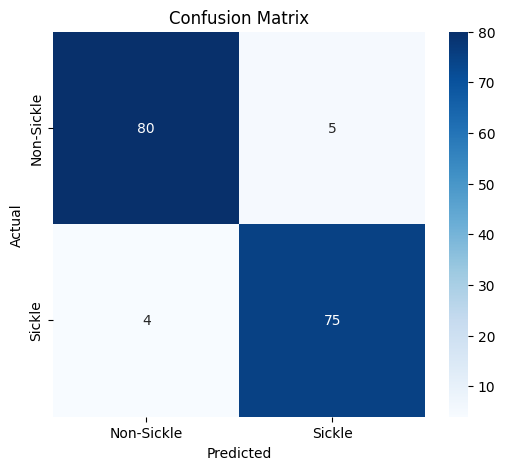

In [9]:
import seaborn as sns
# ✅ Confusion Matrix & Classification Report
cm = confusion_matrix(all_labels, all_preds)

# 📌 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Sickle", "Sickle"], yticklabels=["Non-Sickle", "Sickle"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# 📌 Print Classification Report
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Sickle", "Sickle"]))

📊 Classification Report:
              precision    recall  f1-score   support

  Non-Sickle       0.95      0.94      0.95        85
      Sickle       0.94      0.95      0.94        79

    accuracy                           0.95       164
   macro avg       0.94      0.95      0.95       164
weighted avg       0.95      0.95      0.95       164



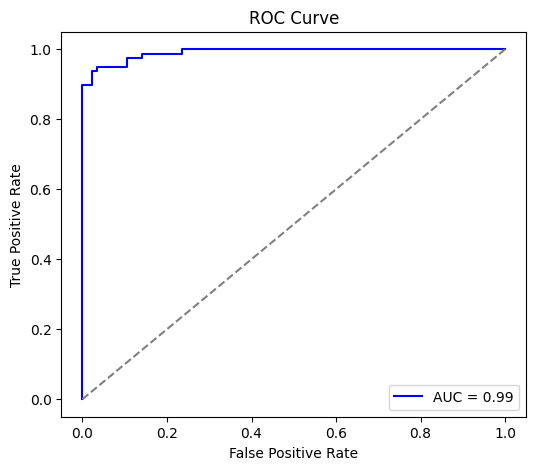

In [11]:
# ✅ ROC Curve & AUC Score
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

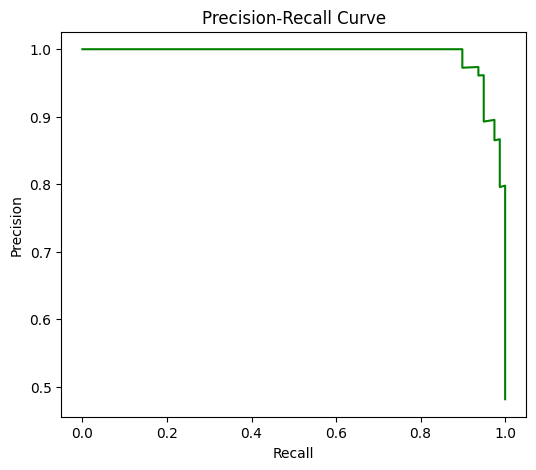

In [12]:
# ✅ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [16]:
from google.colab import files
import io

def predict_image():
    uploaded = files.upload()
    for file_name in uploaded.keys():
        img = Image.open(io.BytesIO(uploaded[file_name]))
        transform_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        img_tensor = transform_test(img).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)

        class_names = ["Non-Sickle Cell", "Sickle Cell"]
        predicted_label = class_names[predicted_class.item()]
        confidence_score = confidence.item() * 100

        # Show results
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_label} ({confidence_score:.2f}%)")
        plt.show()

        # Confidence Score Graph
        plt.figure(figsize=(6, 4))
        plt.bar(class_names, probabilities.cpu().numpy().flatten() * 100, color=["blue", "red"])
        plt.ylabel("Confidence (%)")
        plt.title("Prediction Confidence Levels")
        plt.ylim(0, 100)
        plt.show()




Saving Sickle-Cell-Anemia-2021-722x406.jpg to Sickle-Cell-Anemia-2021-722x406.jpg


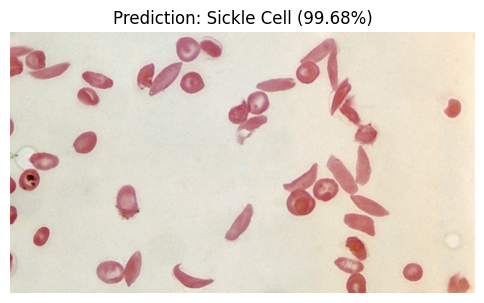

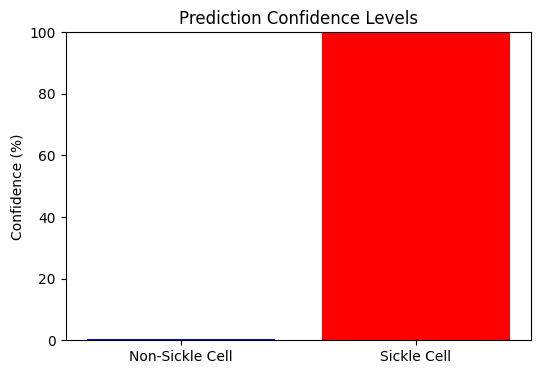

In [17]:
# Run prediction
predict_image()

Saving non 2.tiff to non 2.tiff


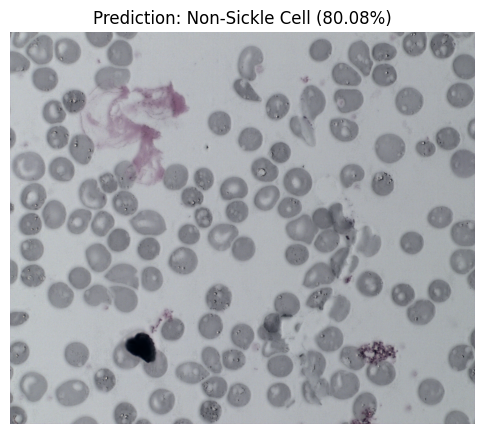

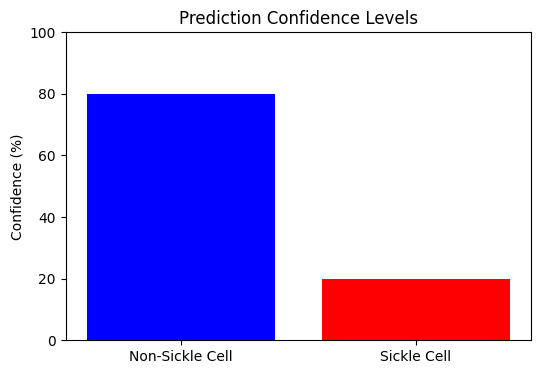

In [24]:
# Run prediction
predict_image()